# Impact of Feature Selection Techniques on Model Performance

In [1]:
import os
import sys

# you may not need to run this cell, you can just run the next cell
# Set environment variable for all subprocesses
os.environ["PYTHONPATH"] = "/mnt/storage/faithfulco/python_packages"

# Add to current interpreter path
sys.path.insert(0, "/mnt/storage/faithfulco/python_packages")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix, 
    RocCurveDisplay
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# libraries
import os
import json
from tqdm import tqdm  # Import tqdm for the progress bar
import pickle
import time  # Import time to track duration
import fastparquet
import pyarrow

/mnt/storage/faithfulco/python_packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df_labels = pd.read_csv('FS_MLRan_Datasets/MLRan_labels.csv') 
print("Shape of the data:", df_labels.shape)
display(df_labels.head())

Shape of the data: (4880, 4)


,sample_id,sample_type,family_label,type_label
0,10001,1,3,2
1,10002,1,12,2
2,10003,1,3,2
3,10004,1,9,1
4,10005,1,11,1


In [4]:
train_sampleids = pd.read_csv('FS_MLRan_Datasets/type_train_sampleids.csv')
print(train_sampleids.shape)
train_sampleids.head()

(3905, 1)


,sample_id
0,15141
1,13905
2,14531
3,14502
4,15584


In [5]:
test_sampleids = pd.read_csv('FS_MLRan_Datasets/type_test_sampleids.csv')
print(test_sampleids.shape)
test_sampleids.head()

(975, 1)


,sample_id
0,13541
1,14058
2,13941
3,13749
4,14097


In [6]:
df_labels_train = df_labels[df_labels['sample_id'].isin(train_sampleids['sample_id'])]
print(df_labels_train.shape)
df_labels_train.head()

(3905, 4)


,sample_id,sample_type,family_label,type_label
0,10001,1,3,2
1,10002,1,12,2
2,10003,1,3,2
3,10004,1,9,1
4,10005,1,11,1


In [7]:
df_labels_test = df_labels[df_labels['sample_id'].isin(test_sampleids['sample_id'])]
print(df_labels_test.shape)
df_labels_test.head()

(975, 4)


,sample_id,sample_type,family_label,type_label
979,11027,1,8,1
982,11030,1,31,2
985,11033,1,8,1
987,11035,1,8,1
988,11036,1,3,2


In [8]:
X_train_m1 = pd.read_parquet('FS_MLRan_Datasets/MLRan_X_train_MI_01.parquet', engine='fastparquet')  # or 'fastparquet'
print(X_train_m1.shape)
display(X_train_m1.head())

(3905, 24163)


,sample_id,1,2,4,5,8,10,16,18,19,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
0,10001,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10002,0,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10003,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,10004,0,0,1,1,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,10005,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,1,0,1


In [9]:
X_test_m1 = pd.read_parquet('FS_MLRan_Datasets/MLRan_X_test_MI_01.parquet', engine='fastparquet')  # or 'fastparquet'
print(X_test_m1.shape)
display(X_test_m1.head())

(975, 24163)


,sample_id,1,2,4,5,8,10,16,18,19,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
0,11027,0,0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,11030,0,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,11033,0,0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,11035,0,0,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,11036,0,0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_train_merge = pd.merge(df_labels_train, X_train_m1, on='sample_id')
print(X_train_merge.shape)
display(X_train_merge.head())
display(X_train_merge.tail())

(3905, 24166)


,sample_id,sample_type,family_label,type_label,1,2,4,5,8,10,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
0,10001,1,3,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10002,1,12,2,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,10003,1,3,2,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,10004,1,9,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10005,1,11,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,1


,sample_id,sample_type,family_label,type_label,1,2,4,5,8,10,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
3900,15691,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3901,15692,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3902,15693,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3903,15694,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3904,15695,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_test_merge = pd.merge(df_labels_test, X_test_m1, on='sample_id')
print(X_test_merge.shape)
display(X_test_merge.head())
display(X_test_merge.tail())

(975, 24166)


,sample_id,sample_type,family_label,type_label,1,2,4,5,8,10,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
0,11027,1,8,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,11030,1,31,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11033,1,8,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,11035,1,8,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,11036,1,3,2,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


,sample_id,sample_type,family_label,type_label,1,2,4,5,8,10,...,6468225,6468226,6468229,6468230,6468242,6468252,6468253,6468256,6468258,6468260
970,15644,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
971,15657,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
972,15661,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
973,15673,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
974,15681,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Extract features and labels
label_column = 'sample_type'
X_train = X_train_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label']).values
y_train = X_train_merge[label_column].values.ravel()

X_test = X_test_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label']).values
y_test = X_test_merge[label_column].values.ravel()

The code below defines a function called perform_rfe_analysis, which performs Recursive Feature Elimination (RFE) using logistic regression as the estimator. The goal is to evaluate the balanced accuracy of the model at different percentages of features selected and return the results.

This code defines a function, `perform_rfe_analysis`, to evaluate the impact of feature selection on the performance of a logistic regression model using **Recursive Feature Elimination (RFE)**. The function operates by progressively reducing the number of features and measuring the model's performance using **balanced accuracy**, a metric particularly suited for imbalanced datasets. It first initialises a logistic regression model with the `saga` solver, optimised for large and sparse datasets, and specifies a high iteration limit (`max_iter=10000`) to ensure convergence. The feature selection percentages to evaluate are predefined as `[1, 2, 3, 4, 5, 10, 20, 50, 70, 90]`, and for each percentage, the corresponding number of features is calculated relative to the training data size.

For each percentage, the code performs RFE to rank the importance of features based on the logistic regression model's coefficients, selecting the specified subset of features. After fitting RFE, the test data is transformed to retain only the selected features, and the logistic regression model is retrained on the reduced feature set. The balanced accuracy is computed by comparing the model's predictions on the test set to the true labels. These accuracy scores are stored in a dictionary, with the feature selection percentages as keys. The function returns this dictionary as the final output, providing insight into how the balanced accuracy varies with different levels of feature selection. This approach highlights the optimal number of features to retain for a high-performing, computationally efficient model.

In [13]:
def perform_rfe_analysis(X_train, X_test, y_train, y_test):
    """
    Perform Recursive Feature Elimination (RFE) with logistic regression,
    evaluate balanced accuracy, and return results.

    Parameters:
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training labels
    - y_test: Testing labels

    Returns:
    - dict: A dictionary with percentages as keys and balanced accuracies as values.
    """
    print("Initialising logistic regression model...")
    model = LogisticRegression(max_iter=10000, solver='saga', random_state=42)

    print("Defining feature selection percentages...")
    #percentages = [1, 2, 3, 4, 5, 10, 20, 50, 70, 90]  # Define percentages of features to select
    percentages = [3, 4, 5, 10, 20, 50, 70, 90]  # Define percentages of features to select

    feature_counts = [int((p / 100) * X_train.shape[1]) for p in percentages]

    balanced_accuracies = {}  # To store balanced accuracy scores

    print("Starting RFE process...")
    for i, num_features in enumerate(feature_counts):
        print(f"Performing RFE for {percentages[i]}% of features ({num_features} features)...")
        rfe = RFE(estimator=model, n_features_to_select=num_features, step=0.1)
        rfe.fit(X_train, y_train)

        print("Transforming test set...")
        X_test_transformed = rfe.transform(X_test)
        
        print("Fitting logistic regression model on selected features...")
        model.fit(rfe.transform(X_train), y_train)

        print("Making predictions and calculating balanced accuracy...")
        y_pred = model.predict(X_test_transformed)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        print(f"Balanced accuracy for {percentages[i]}% is ({balanced_acc} )")
        balanced_accuracies[percentages[i]] = balanced_acc

    print("RFE process completed.")
    return balanced_accuracies

In [ ]:
balanced_accuracies = perform_rfe_analysis(X_train, X_test, y_train, y_test)
print(balanced_accuracies)      

Initialising logistic regression model...
Defining feature selection percentages...
Starting RFE process...
Performing RFE for 1% of features (241 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculating balanced accuracy...
Balanced accuracy for 1% is (0.9705249841872232 )
Performing RFE for 2% of features (483 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculating balanced accuracy...
Balanced accuracy for 2% is (0.980708412397217 )
Performing RFE for 3% of features (724 features)...


In [14]:
balanced_accuracies = perform_rfe_analysis(X_train, X_test, y_train, y_test)
print(balanced_accuracies)    

Initialising logistic regression model...
Defining feature selection percentages...
Starting RFE process...
Performing RFE for 3% of features (724 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculating balanced accuracy...
Balanced accuracy for 3% is (0.9788425047438329 )
Performing RFE for 4% of features (966 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculating balanced accuracy...
Balanced accuracy for 4% is (0.976786843769766 )
Performing RFE for 5% of features (1208 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculating balanced accuracy...
Balanced accuracy for 5% is (0.9778621125869702 )
Performing RFE for 10% of features (2416 features)...
Transforming test set...
Fitting logistic regression model on selected features...
Making predictions and calculati

In [35]:
balanced_accuracies = {1: 0.9705249841872232, 2: 0.980708412397217, 3: 0.9788425047438329, 4: 0.976786843769766, 5: 0.9778621125869702, 10: 0.9779569892473119, 20: 0.9778621125869702, 50: 0.9759962049335864, 70: 0.9759962049335864, 90: 0.9769765970904492}
balanced_accuracies

{1: 0.9705249841872232,
 2: 0.980708412397217,
 3: 0.9788425047438329,
 4: 0.976786843769766,
 5: 0.9778621125869702,
 10: 0.9779569892473119,
 20: 0.9778621125869702,
 50: 0.9759962049335864,
 70: 0.9759962049335864,
 90: 0.9769765970904492}

Plotting results...


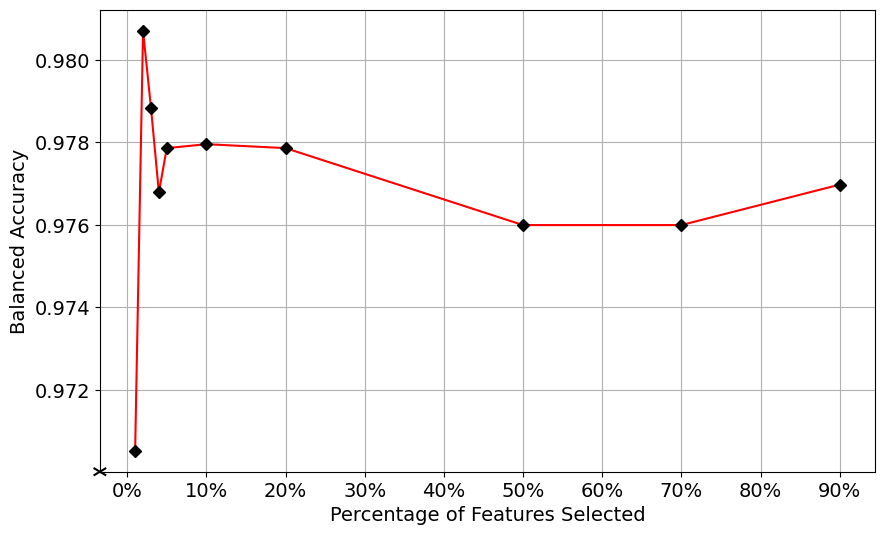

In [36]:
%matplotlib inline

#Plot balanced accuracy scores against percentages of features selected.
percentages = list(balanced_accuracies.keys())
accuracies = list(balanced_accuracies.values())

print("Plotting results...")
plt.figure(figsize=(10, 6))
plt.plot(percentages, accuracies, color='red', marker='D', markerfacecolor='black', markeredgecolor='black', linestyle='-')
#plt.title("Impact of Recursive Feature Elimination Feature Selection Technique", fontsize=16)
plt.xlabel("Percentage of Features Selected", fontsize=14)
plt.ylabel("Balanced Accuracy", fontsize=14)
plt.grid()

# Ensure x-axis shows ticks at intervals of 10
plt.xticks(range(0, 101, 10), [f"{x}%" for x in range(0, 101, 10)], fontsize=14)
plt.yticks(fontsize=14)

# Add break symbol (zigzag) on the y-axis...to show it does not start from 0
import matplotlib.patches as patches
ax = plt.gca()
d = 0.007  # Size of diagonal break
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # Bottom-left diagonal
ax.plot((+d, -d), (-d, +d), **kwargs)  # Bottom-right diagonal

# Save the plot
plt.savefig('outputs/2_Impact_FS/rfe_balance_accuracy_new.pdf', format='pdf' ,bbox_inches='tight')

plt.show()


**Caption:** Figure 1: This plot shows the balanced accuracy of a logistic regression model as a function of the percentage of features selected using Recursive Feature Elimination (RFE). The initial dataset contains 24,162 features, and RFE is used to iteratively select subsets of features corresponding to 1%, 2%, 5%, 10%, 20%, 50%, 70%, and 90% of the original feature set. The highest balanced accuracy (0.9787) is achieved when only 2% of the features (483 features) are selected, demonstrating that careful feature selection can improve model performance while reducing computational complexity.

In [17]:
print("Initialising logistic regression model...")
model = LogisticRegression(max_iter=10000, solver='liblinear', C=1, penalty= 'l2', random_state=42)
print("Performing Recursive Feature Elimination (RFE)...")
rfe = RFE(estimator=model, n_features_to_select=483, step=0.1)
rfe.fit(X_train, y_train)

# Get the boolean mask of selected features
selected_features_mask = rfe.support_

Initialising logistic regression model...
Performing Recursive Feature Elimination (RFE)...


In [18]:
print("Length of features mask:", len(selected_features_mask))
print("Selected features mask:", selected_features_mask)

Length of features mask: 24162
Selected features mask: [False False False ... False False False]


In [19]:
# Extract features and labels
label_column = 'sample_type'
X_train_2 = X_train_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])

X_test_2 = X_test_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])

In [20]:
selected_feature_names = X_train_2.columns[selected_features_mask]
print("length of selected features:",selected_feature_names)

length of selected features: Index(['5', '8', '18', '32', '33', '34', '35', '37', '41', '43',
       ...
       '6468165', '6468166', '6468169', '6468170', '6468193', '6468195',
       '6468200', '6468202', '6468204', '6468211'],
      dtype='object', length=483)


In [21]:
# Mandatory columns to include in the selected features
mandatory_features = ['sample_id', 'sample_type', 'family_label', 'type_label']

# Combine RFE-selected features with mandatory features
final_selected_feature_names = mandatory_features + list(selected_feature_names)

# Get the data in X_train_2 corresponding to the selected feature names
X_train_selected = X_train_merge[final_selected_feature_names]

# Print the shape of the resulting DataFrame and a sample
print("Shape of the selected features' data:", X_train_selected.shape)
print("Sample of the data corresponding to selected features:")
display(X_train_selected.head())


Shape of the selected features' data: (3905, 487)
Sample of the data corresponding to selected features:


,sample_id,sample_type,family_label,type_label,5,8,18,32,33,34,...,6468165,6468166,6468169,6468170,6468193,6468195,6468200,6468202,6468204,6468211
0,10001,1,3,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10002,1,12,2,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,10003,1,3,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10004,1,9,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,10005,1,11,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,0


In [22]:
# Mandatory columns to include in the selected features
mandatory_features = ['sample_id', 'sample_type', 'family_label', 'type_label']

# Combine RFE-selected features with mandatory features
final_selected_feature_names = mandatory_features + list(selected_feature_names)

# Get the data in X_train_2 corresponding to the selected feature names
X_test_selected = X_test_merge[final_selected_feature_names]

# Print the shape of the resulting DataFrame and a sample
print("Shape of the selected features' data:", X_test_selected.shape)
print("Sample of the data corresponding to selected features:")
display(X_test_selected.head())

Shape of the selected features' data: (975, 487)
Sample of the data corresponding to selected features:


,sample_id,sample_type,family_label,type_label,5,8,18,32,33,34,...,6468165,6468166,6468169,6468170,6468193,6468195,6468200,6468202,6468204,6468211
0,11027,1,8,1,1,1,1,1,1,1,...,1,0,1,1,0,0,0,0,1,1
1,11030,1,31,2,1,0,1,0,1,1,...,0,1,0,0,0,0,1,0,1,1
2,11033,1,8,1,1,1,1,1,1,1,...,1,0,1,1,0,0,0,0,1,1
3,11035,1,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
4,11036,1,3,2,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#X_train_selected.to_csv('FS_MLRan_Datasets/MLRan_X_train_RFE.csv', index=False)
#X_test_selected.to_csv('FS_MLRan_Datasets/MLRan_X_test_RFE.csv', index=False)

In [5]:
# Libraries for the pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

# Preprocessing step to clean and prepare the data
def preprocess_data(X_train_merge, X_test_merge, label_column, is_multiclass=False):
    # Drop metadata columns and preserve feature names
    X_train = X_train_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_train = X_train_merge[label_column].to_numpy()

    X_test = X_test_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_test = X_test_merge[label_column].to_numpy()

    return X_train, y_train, X_test, y_test, None

# Retrieve list of models to train depending on classification type

def get_models(is_multiclass):
    common_params = {'n_jobs': -1}
    if is_multiclass:
        return [
            (LGBMClassifier(objective='multiclass', verbose=0, min_child_samples=10,
    min_split_gain=0, **common_params), "LightGBM"),
            (DecisionTreeClassifier(), "Decision Tree"),
            (LogisticRegression(max_iter=1000, verbose=0), "Logistic Regression"),
            (RandomForestClassifier(verbose=0), "Random Forest"),
            (ExtraTreesClassifier(verbose=0, **common_params), "Extra Trees")
        ]
    else:
        return [
            (LGBMClassifier(objective='binary', verbose=0, min_child_samples=10,
    min_split_gain=0, **common_params), "LightGBM"),
            (DecisionTreeClassifier(), "Decision Tree"),
            (LogisticRegression(max_iter=1000, verbose=0), "Logistic Regression"),
            (RandomForestClassifier(verbose=0), "Random Forest"),
            (ExtraTreesClassifier(verbose=0, **common_params), "Extra Trees")
        ]

# Define hyperparameter search grids for each model

def get_hyperparameter_grid(model_name, is_multiclass):
    if model_name == "LightGBM":
        return {
            'num_leaves': [15, 31],
            'n_estimators': [50, 100],
            'learning_rate': [0.01]
        }
    elif model_name == "Decision Tree":
        return {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif model_name == "Logistic Regression":
        return {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs'] if is_multiclass else ['liblinear']
        }
    elif model_name == "Random Forest":
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    elif model_name == "Extra Trees":
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    else:
        return {}

# Function to train and evaluate a single model

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, is_multiclass):
    print(f"Starting training for {model_name}...")

    param_grid = get_hyperparameter_grid(model_name, is_multiclass)
    if param_grid:
        print(f"Starting hyperparameter tuning for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='f1_weighted' if is_multiclass else 'roc_auc',
            cv=3, n_jobs=-1, verbose=0
        )
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Completed hyperparameter tuning for {model_name}.")
    else:
        print(f"Training {model_name} without hyperparameter tuning...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        best_model = model
        best_params = {}

    print(f"{model_name} training completed.")
    training_time = end_time - start_time

    print(f"Starting prediction for {model_name}...")
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

    if is_multiclass and y_prob is not None:
        y_prob_aligned = np.zeros((y_prob.shape[0], len(np.unique(np.concatenate((y_train, y_test))))))
        for i, cls in enumerate(np.unique(y_train)):
            y_prob_aligned[:, cls] = y_prob[:, i]
        y_prob = y_prob_aligned

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    if is_multiclass and y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
        except ValueError:
            roc_auc = None
    elif y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
    else:
        roc_auc = None

    print(f"Classification Report - {model_name}:\n{classification_report(y_test, y_pred)}")

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Display ROC curve for binary classification
    if y_prob is not None and not is_multiclass:
        RocCurveDisplay.from_predictions(y_test, y_prob[:, 1])
        plt.title(f"ROC Curve - {model_name}")
        plt.show()

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Training Time (s)": training_time,
        "Best Hyperparameters": best_params
    }

# Function to iterate over all models

def train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column):
    is_multiclass = label_column in ["type_label", "family_label"]
    models = get_models(is_multiclass)
    metrics_list = []

    for model, name in models:
        print("="*60)
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name, is_multiclass)
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list).round(4)
    if is_multiclass:
        metrics_df['Label Mapping'] = str(dict(enumerate(np.unique(y_train))))
    metrics_df['Best Hyperparameters'] = metrics_df['Best Hyperparameters'].apply(lambda x: str(x))
    return metrics_df

# Main function to run the pipeline

def main(X_train_merge, X_test_merge, label_column):
    print("Starting preprocessing...")
    is_multiclass = label_column in ["type_label", "family_label"]

    X_train, y_train, X_test, y_test, label_encoder = preprocess_data(
        X_train_merge, X_test_merge, label_column, is_multiclass
    )

    print("Preprocessing complete. Beginning model training and evaluation...")
    metrics_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column)
    print("Model Performance Metrics:")
    display(metrics_df)
    return metrics_df


## Load data

In [3]:
X_train_merge_rfe = pd.read_csv('FS_MLRan_Datasets/MLRan_X_train_RFE.csv')
X_test_merge_rfe = pd.read_csv('FS_MLRan_Datasets/MLRan_X_test_RFE.csv')
print(X_train_merge_rfe.shape)
print(X_test_merge_rfe.shape)
display(X_train_merge_rfe.head())
display(X_test_merge_rfe.head())

(3905, 487)
(975, 487)


,sample_id,sample_type,family_label,type_label,5,8,18,32,33,34,...,6468165,6468166,6468169,6468170,6468193,6468195,6468200,6468202,6468204,6468211
0,10001,1,3,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10002,1,12,2,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,10003,1,3,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10004,1,9,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,10005,1,11,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,0


,sample_id,sample_type,family_label,type_label,5,8,18,32,33,34,...,6468165,6468166,6468169,6468170,6468193,6468195,6468200,6468202,6468204,6468211
0,11027,1,8,1,1,1,1,1,1,1,...,1,0,1,1,0,0,0,0,1,1
1,11030,1,31,2,1,0,1,0,1,1,...,0,1,0,0,0,0,1,0,1,1
2,11033,1,8,1,1,1,1,1,1,1,...,1,0,1,1,0,0,0,0,1,1
3,11035,1,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
4,11036,1,3,2,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Binary classification

Starting preprocessing...
Preprocessing complete. Beginning model training and evaluation...
Starting training for LightGBM...
Starting hyperparameter tuning for LightGBM...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

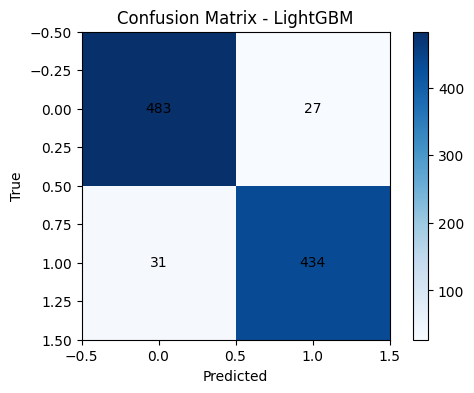

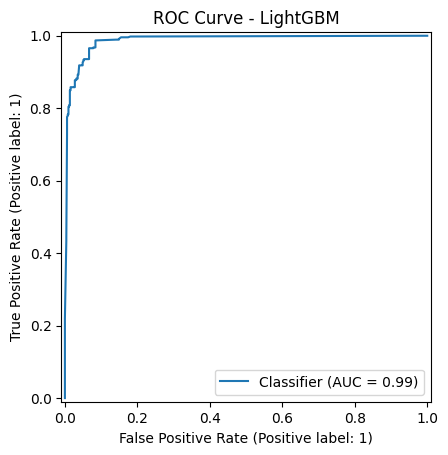

Starting training for Decision Tree...
Starting hyperparameter tuning for Decision Tree...
Completed hyperparameter tuning for Decision Tree.
Decision Tree training completed.
Starting prediction for Decision Tree...
Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       510
           1       0.95      0.91      0.93       465

    accuracy                           0.94       975
   macro avg       0.94      0.93      0.94       975
weighted avg       0.94      0.94      0.94       975



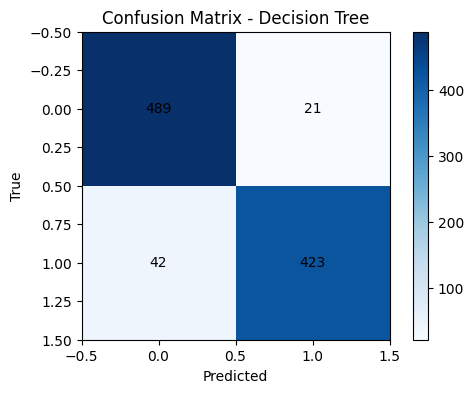

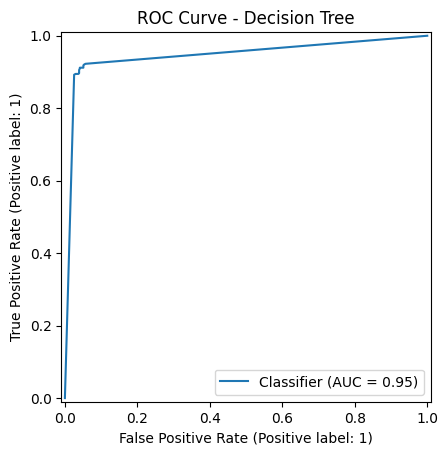

Starting training for Logistic Regression...
Starting hyperparameter tuning for Logistic Regression...
Completed hyperparameter tuning for Logistic Regression.
Logistic Regression training completed.
Starting prediction for Logistic Regression...
Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       510
           1       0.97      0.99      0.98       465

    accuracy                           0.98       975
   macro avg       0.98      0.98      0.98       975
weighted avg       0.98      0.98      0.98       975



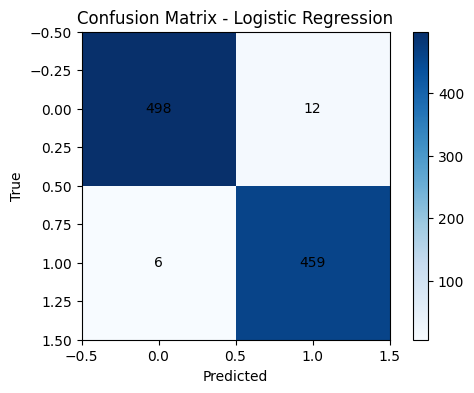

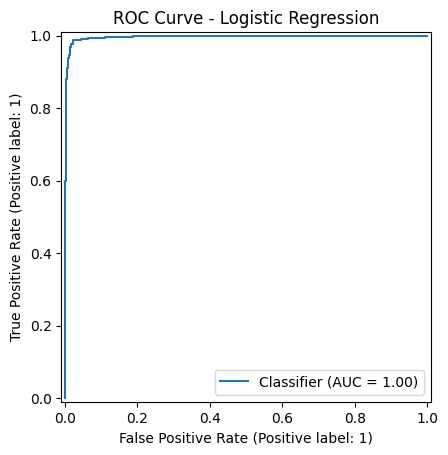

Starting training for Random Forest...
Starting hyperparameter tuning for Random Forest...
Completed hyperparameter tuning for Random Forest.
Random Forest training completed.
Starting prediction for Random Forest...
Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       510
           1       0.96      0.97      0.96       465

    accuracy                           0.97       975
   macro avg       0.97      0.97      0.97       975
weighted avg       0.97      0.97      0.97       975



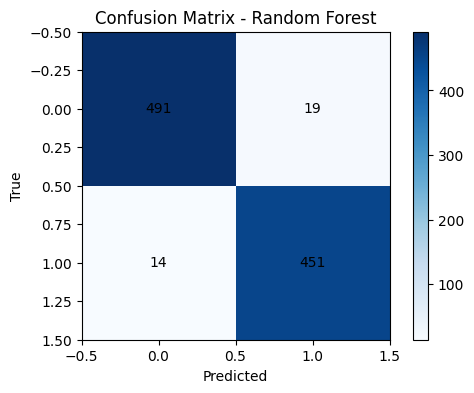

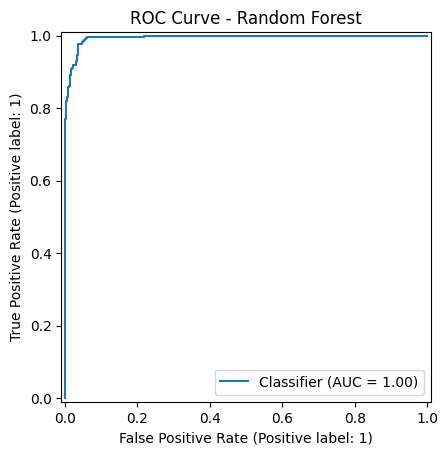

Starting training for Extra Trees...
Starting hyperparameter tuning for Extra Trees...
Completed hyperparameter tuning for Extra Trees.
Extra Trees training completed.
Starting prediction for Extra Trees...
Classification Report - Extra Trees:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       510
           1       0.96      0.98      0.97       465

    accuracy                           0.97       975
   macro avg       0.97      0.97      0.97       975
weighted avg       0.97      0.97      0.97       975



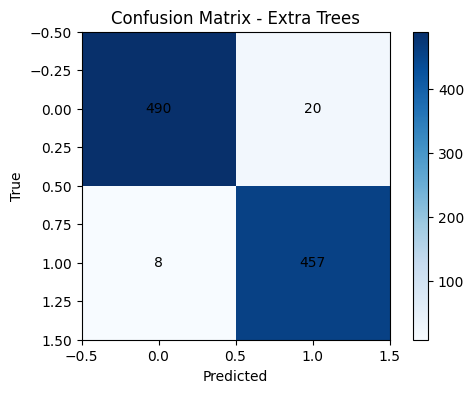

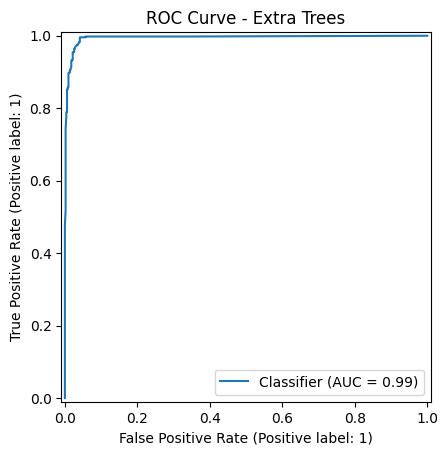

Model Performance Metrics:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters
0,LightGBM,0.9405,0.9402,0.9405,0.9405,0.9405,0.9873,1206.5883,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
1,Decision Tree,0.9354,0.9343,0.9361,0.9354,0.9353,0.9464,12.1335,"{'max_depth': 20, 'min_samples_split': 10}"
2,Logistic Regression,0.9815,0.9818,0.9816,0.9815,0.9815,0.9968,0.8578,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
3,Random Forest,0.9662,0.9663,0.9662,0.9662,0.9662,0.9951,2.2099,"{'max_depth': None, 'min_samples_split': 5, 'n..."
4,Extra Trees,0.9713,0.9718,0.9716,0.9713,0.9713,0.9946,1.5969,"{'max_depth': 20, 'min_samples_split': 2, 'n_e..."


In [27]:
metrics_df_sample = main(X_train_merge_rfe, X_test_merge_rfe, label_column="sample_type")

In [28]:
display(metrics_df_sample)
metrics_df_sample.to_csv('outputs/2_Impact_FS/binary_rfe_results.csv', index=False)

,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters
0,LightGBM,0.9405,0.9402,0.9405,0.9405,0.9405,0.9873,1206.5883,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
1,Decision Tree,0.9354,0.9343,0.9361,0.9354,0.9353,0.9464,12.1335,"{'max_depth': 20, 'min_samples_split': 10}"
2,Logistic Regression,0.9815,0.9818,0.9816,0.9815,0.9815,0.9968,0.8578,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
3,Random Forest,0.9662,0.9663,0.9662,0.9662,0.9662,0.9951,2.2099,"{'max_depth': None, 'min_samples_split': 5, 'n..."
4,Extra Trees,0.9713,0.9718,0.9716,0.9713,0.9713,0.9946,1.5969,"{'max_depth': 20, 'min_samples_split': 2, 'n_e..."


## Multi-class ransomware types

Starting preprocessing...
Preprocessing complete. Beginning model training and evaluation...
Starting training for LightGBM...
Starting hyperparameter tuning for LightGBM...
Completed hyperparameter tuning for LightGBM.
LightGBM training completed.
Starting prediction for LightGBM...
Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       510
           1       0.91      0.91      0.91        55
           2       0.70      0.68      0.69       228
           3       0.54      0.70      0.61        92
           4       0.81      0.42      0.55        90

    accuracy                           0.82       975
   macro avg       0.78      0.73      0.74       975
weighted avg       0.82      0.82      0.81       975



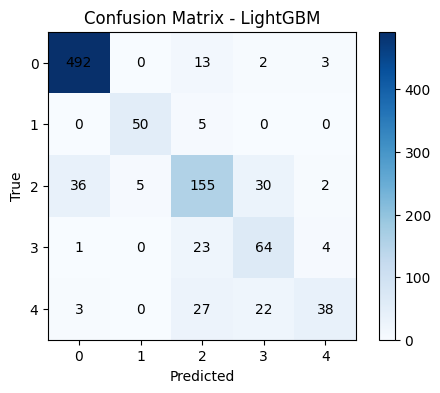

Starting training for Decision Tree...
Starting hyperparameter tuning for Decision Tree...
Completed hyperparameter tuning for Decision Tree.
Decision Tree training completed.
Starting prediction for Decision Tree...
Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       510
           1       0.77      0.65      0.71        55
           2       0.78      0.74      0.76       228
           3       0.58      0.82      0.68        92
           4       0.72      0.56      0.63        90

    accuracy                           0.84       975
   macro avg       0.76      0.74      0.74       975
weighted avg       0.84      0.84      0.84       975



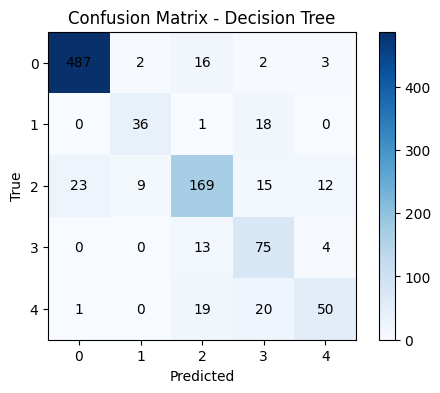

Starting training for Logistic Regression...
Starting hyperparameter tuning for Logistic Regression...
Completed hyperparameter tuning for Logistic Regression.
Logistic Regression training completed.
Starting prediction for Logistic Regression...
Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       510
           1       0.87      0.98      0.92        55
           2       0.85      0.76      0.80       228
           3       0.51      0.76      0.61        92
           4       0.74      0.51      0.61        90

    accuracy                           0.86       975
   macro avg       0.79      0.80      0.78       975
weighted avg       0.88      0.86      0.87       975



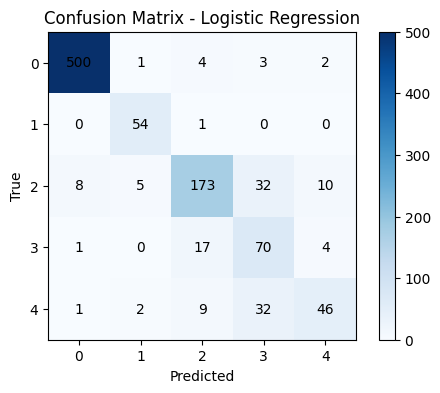

Starting training for Random Forest...
Starting hyperparameter tuning for Random Forest...
Completed hyperparameter tuning for Random Forest.
Random Forest training completed.
Starting prediction for Random Forest...
Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       510
           1       0.90      0.84      0.87        55
           2       0.79      0.78      0.78       228
           3       0.60      0.83      0.69        92
           4       0.81      0.56      0.66        90

    accuracy                           0.87       975
   macro avg       0.81      0.79      0.79       975
weighted avg       0.87      0.87      0.87       975



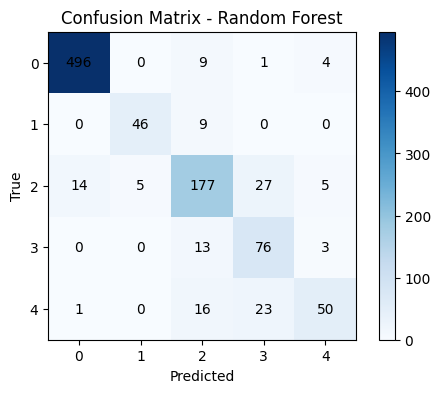

Starting training for Extra Trees...
Starting hyperparameter tuning for Extra Trees...
Completed hyperparameter tuning for Extra Trees.
Extra Trees training completed.
Starting prediction for Extra Trees...
Classification Report - Extra Trees:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       510
           1       0.90      0.84      0.87        55
           2       0.78      0.80      0.79       228
           3       0.63      0.80      0.71        92
           4       0.82      0.62      0.71        90

    accuracy                           0.88       975
   macro avg       0.82      0.81      0.81       975
weighted avg       0.88      0.88      0.88       975



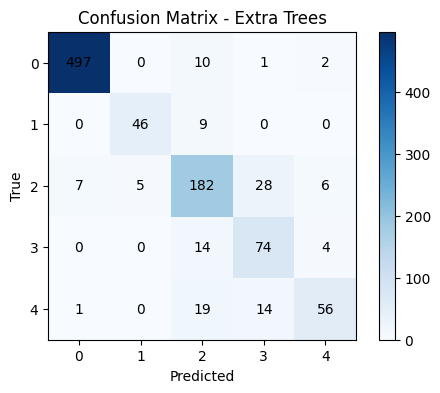

Model Performance Metrics:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,LightGBM,0.8195,0.7343,0.8234,0.8195,0.8147,0.9656,5447.4573,"{'learning_rate': 0.01, 'n_estimators': 100, '...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
1,Decision Tree,0.8379,0.7443,0.8443,0.8379,0.8378,0.9108,12.1728,"{'max_depth': 20, 'min_samples_split': 5}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
2,Logistic Regression,0.8646,0.7986,0.8770,0.8646,0.8657,0.9787,1.3116,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
3,Random Forest,0.8667,0.7934,0.8743,0.8667,0.8665,0.9820,2.6745,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
4,Extra Trees,0.8769,0.8071,0.8832,0.8769,0.8777,0.9823,1.6061,"{'max_depth': None, 'min_samples_split': 5, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."


In [29]:
metrics_df_type = main(X_train_merge_rfe, X_test_merge_rfe, label_column="type_label")

In [30]:
display(metrics_df_type)
metrics_df_type.to_csv('outputs/2_Impact_FS/types_rfe_results.csv', index=False)

,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,LightGBM,0.8195,0.7343,0.8234,0.8195,0.8147,0.9656,5447.4573,"{'learning_rate': 0.01, 'n_estimators': 100, '...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
1,Decision Tree,0.8379,0.7443,0.8443,0.8379,0.8378,0.9108,12.1728,"{'max_depth': 20, 'min_samples_split': 5}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
2,Logistic Regression,0.8646,0.7986,0.8770,0.8646,0.8657,0.9787,1.3116,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
3,Random Forest,0.8667,0.7934,0.8743,0.8667,0.8665,0.9820,2.6745,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
4,Extra Trees,0.8769,0.8071,0.8832,0.8769,0.8777,0.9823,1.6061,"{'max_depth': None, 'min_samples_split': 5, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."


In [11]:
# Libraries for the pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np
import pandas as pd
import time

# Preprocessing step to clean and prepare the data
def preprocess_data(X_train_merge, X_test_merge, label_column, is_multiclass=False):
    X_train = X_train_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_train = X_train_merge[label_column].to_numpy()

    X_test = X_test_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_test = X_test_merge[label_column].to_numpy()

    return X_train, y_train, X_test, y_test, None

# Retrieve list of models to train depending on classification type
def get_models(is_multiclass):
    common_params = {'n_jobs': -1}
    return [
        (DecisionTreeClassifier(), "Decision Tree"),
        (LogisticRegression(max_iter=1000, verbose=0), "Logistic Regression"),
        (RandomForestClassifier(verbose=0), "Random Forest"),
        (ExtraTreesClassifier(verbose=0, **common_params), "Extra Trees")
    ]

# Define hyperparameter search grids for each model
def get_hyperparameter_grid(model_name, is_multiclass):
    if model_name == "Decision Tree":
        return {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif model_name == "Logistic Regression":
        return {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs'] if is_multiclass else ['liblinear']
        }
    elif model_name == "Random Forest":
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    elif model_name == "Extra Trees":
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    else:
        return {}

# Function to train and evaluate a single model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, is_multiclass):
    print(f"Starting training for {model_name}...")

    param_grid = get_hyperparameter_grid(model_name, is_multiclass)
    if param_grid:
        print(f"Starting hyperparameter tuning for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='f1_weighted' if is_multiclass else 'roc_auc',
            cv=3, n_jobs=-1, verbose=0
        )
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Completed hyperparameter tuning for {model_name}.")
    else:
        print(f"Training {model_name} without hyperparameter tuning...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        best_model = model
        best_params = {}

    print(f"{model_name} training completed.")
    training_time = end_time - start_time

    print(f"Starting prediction for {model_name}...")
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

    if is_multiclass and y_prob is not None:
        class_labels = np.unique(np.concatenate((y_train, y_test)))
        class_to_index = {label: idx for idx, label in enumerate(class_labels)}
        y_prob_aligned = np.zeros((y_prob.shape[0], len(class_labels)))
        for i, cls in enumerate(best_model.classes_):
            y_prob_aligned[:, class_to_index[cls]] = y_prob[:, i]
        y_prob = y_prob_aligned


    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    if is_multiclass and y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
        except ValueError:
            roc_auc = None
    elif y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
    else:
        roc_auc = None

    print(f"Classification Report - {model_name}:\n{classification_report(y_test, y_pred)}")
    print("accuracy:", accuracy)
    print("balanced_accuracy:", balanced_accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1:", f1)
    print("roc_auc:", roc_auc)
    print("Training Time (s):", training_time)
    print("Best Hyperparameters:", best_params)

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Display ROC curve for binary classification
    if y_prob is not None and not is_multiclass:
        RocCurveDisplay.from_predictions(y_test, y_prob[:, 1])
        plt.title(f"ROC Curve - {model_name}")
        plt.show()

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Training Time (s)": training_time,
        "Best Hyperparameters": best_params
    }

# Function to iterate over all models
def train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column):
    is_multiclass = label_column in ["type_label", "family_label"]
    models = get_models(is_multiclass)
    metrics_list = []

    for model, name in models:
        print("="*60)
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name, is_multiclass)
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list).round(4)
    print("Metrics DataFrame:")
    display(metrics_df)
    if is_multiclass:
        metrics_df['Label Mapping'] = str(dict(enumerate(np.unique(y_train))))
    metrics_df['Best Hyperparameters'] = metrics_df['Best Hyperparameters'].apply(lambda x: str(x))
    return metrics_df

# Main function to run the pipeline
def main(X_train_merge, X_test_merge, label_column):
    print("Starting preprocessing...")
    is_multiclass = label_column in ["type_label", "family_label"]

    X_train, y_train, X_test, y_test, label_encoder = preprocess_data(
        X_train_merge, X_test_merge, label_column, is_multiclass
    )

    print("Preprocessing complete. Beginning model training and evaluation...")
    metrics_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column)
    print("Model Performance Metrics:")
    display(metrics_df)
    return metrics_df


## Multi-class ransomware families

Starting preprocessing...
Preprocessing complete. Beginning model training and evaluation...
Starting training for Decision Tree...
Starting hyperparameter tuning for Decision Tree...


Completed hyperparameter tuning for Decision Tree.
Decision Tree training completed.
Starting prediction for Decision Tree...
Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       510
           1       1.00      0.97      0.98        62
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.36      0.53        47
           7       0.00      0.00      0.00         0
           8       0.90      0.82      0.86        55
           9       0.00      0.00      0.00         0
          10       0.48      0.74      0.58        19
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       1.00 

/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

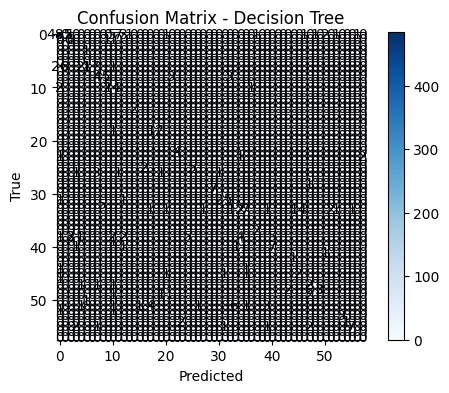

Starting training for Logistic Regression...
Starting hyperparameter tuning for Logistic Regression...
Completed hyperparameter tuning for Logistic Regression.
Logistic Regression training completed.
Starting prediction for Logistic Regression...
Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       510
           1       0.95      0.98      0.97        62
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.89      0.94        47
           7       0.00      0.00      0.00         0
           8       0.91      0.89      0.90        55
          10       0.63      0.63      0.63        19
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         2
     

/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

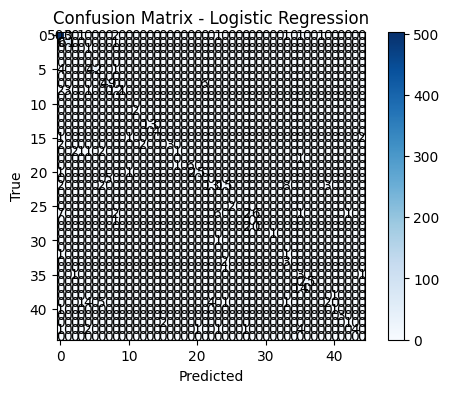

Starting training for Random Forest...
Starting hyperparameter tuning for Random Forest...
Completed hyperparameter tuning for Random Forest.
Random Forest training completed.
Starting prediction for Random Forest...
Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       510
           1       0.88      0.98      0.93        62
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.34      0.51        47
           7       0.00      0.00      0.00         0
           8       0.91      0.89      0.90        55
           9       0.00      0.00      0.00         0
          10       0.57      0.42      0.48        19
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.

/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

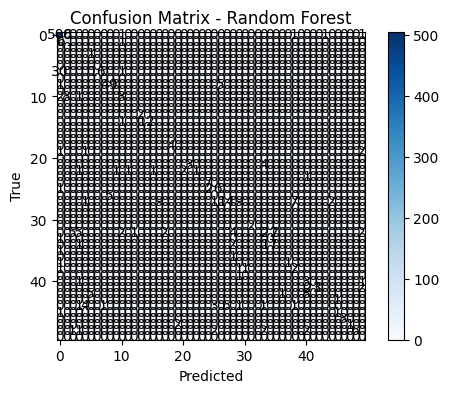

Starting training for Extra Trees...
Starting hyperparameter tuning for Extra Trees...
Completed hyperparameter tuning for Extra Trees.
Extra Trees training completed.
Starting prediction for Extra Trees...


/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

Classification Report - Extra Trees:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       510
           1       0.87      0.97      0.92        62
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.87      0.93        47
           7       0.00      0.00      0.00         0
           8       0.91      0.89      0.90        55
           9       0.00      0.00      0.00         0
          10       0.53      0.42      0.47        19
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         2
          16       0.00      0.00      0.00         0
          20       1.00      0.92      0.96        13
          21       0.00      0.00      0.00 

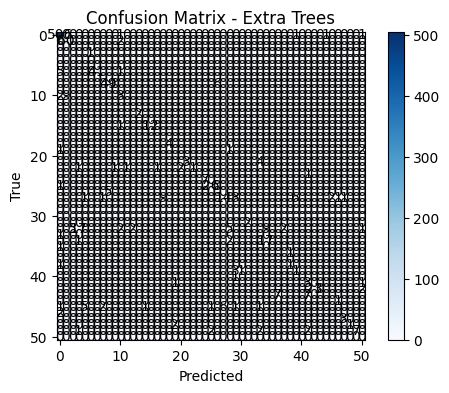

Metrics DataFrame:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters
0,Decision Tree,0.7538,0.4166,0.8084,0.7538,0.7672,None,1.7897,"{'max_depth': None, 'min_samples_split': 2}"
1,Logistic Regression,0.8185,0.4707,0.8370,0.8185,0.8135,None,2.2382,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
2,Random Forest,0.7877,0.4555,0.8082,0.7877,0.7784,None,2.9489,"{'max_depth': None, 'min_samples_split': 2, 'n..."
3,Extra Trees,0.8113,0.4523,0.8335,0.8113,0.8131,None,1.5351,"{'max_depth': None, 'min_samples_split': 2, 'n..."


Model Performance Metrics:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,Decision Tree,0.7538,0.4166,0.8084,0.7538,0.7672,None,1.7897,"{'max_depth': None, 'min_samples_split': 2}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
1,Logistic Regression,0.8185,0.4707,0.8370,0.8185,0.8135,None,2.2382,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
2,Random Forest,0.7877,0.4555,0.8082,0.7877,0.7784,None,2.9489,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
3,Extra Trees,0.8113,0.4523,0.8335,0.8113,0.8131,None,1.5351,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."


In [12]:
metrics_df_family = main(X_train_merge_rfe, X_test_merge_rfe, label_column="family_label")

In [13]:
display(metrics_df_family)
metrics_df_family.to_csv('outputs/2_Impact_FS/family_rfe_results.csv', index=False)

,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,Decision Tree,0.7538,0.4166,0.8084,0.7538,0.7672,None,1.7897,"{'max_depth': None, 'min_samples_split': 2}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
1,Logistic Regression,0.8185,0.4707,0.8370,0.8185,0.8135,None,2.2382,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
2,Random Forest,0.7877,0.4555,0.8082,0.7877,0.7784,None,2.9489,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
3,Extra Trees,0.8113,0.4523,0.8335,0.8113,0.8131,None,1.5351,"{'max_depth': None, 'min_samples_split': 2, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."


In [4]:
# Libraries for the pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import time

# Preprocessing step to clean and prepare the data
def preprocess_data(X_train_merge, X_test_merge, label_column, is_multiclass=False):
    X_train = X_train_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_train = X_train_merge[label_column].to_numpy()

    X_test = X_test_merge.drop(columns=['sample_id', 'sample_type', 'family_label', 'type_label'])
    y_test = X_test_merge[label_column].to_numpy()

    return X_train, y_train, X_test, y_test, None

# Retrieve list of models to train depending on classification type
def get_models(is_multiclass):
    common_params = {'n_jobs': -1, 'verbose': -1}
    if is_multiclass:
        model = LGBMClassifier(objective='multiclass', min_child_samples=10, min_split_gain=0, **common_params)
    else:
        model = LGBMClassifier(objective='binary', min_child_samples=10, min_split_gain=0, **common_params)
    return [(model, "LightGBM")]

# Define hyperparameter search grid for LightGBM
def get_hyperparameter_grid(model_name, is_multiclass):
    if model_name == "LightGBM":
        return {
            'num_leaves': [15], # [15, 31],
            'n_estimators': [50], # [50, 100],
            'learning_rate': [0.01]
        }
    else:
        return {}

# Function to train and evaluate a single model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, is_multiclass):
    print(f"Starting training for {model_name}...")

    param_grid = get_hyperparameter_grid(model_name, is_multiclass)
    if param_grid:
        print(f"Starting hyperparameter tuning for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='f1_weighted' if is_multiclass else 'roc_auc',
            cv=3, n_jobs=-1, verbose=0
        )
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Completed hyperparameter tuning for {model_name}.")
    else:
        print(f"Training {model_name} without hyperparameter tuning...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        best_model = model
        best_params = {}

    print(f"{model_name} training completed.")
    training_time = end_time - start_time

    print(f"Starting prediction for {model_name}...")
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

    if is_multiclass and y_prob is not None:
        class_labels = np.unique(np.concatenate((y_train, y_test)))
        class_to_index = {label: idx for idx, label in enumerate(class_labels)}
        y_prob_aligned = np.zeros((y_prob.shape[0], len(class_labels)))
        for i, cls in enumerate(best_model.classes_):
            y_prob_aligned[:, class_to_index[cls]] = y_prob[:, i]
        y_prob = y_prob_aligned

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    if is_multiclass and y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
        except ValueError:
            roc_auc = None
    elif y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
    else:
        roc_auc = None

    print(f"Classification Report - {model_name}:\n{classification_report(y_test, y_pred)}")
    print("accuracy:", accuracy)
    print("balanced_accuracy:", balanced_accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1:", f1)
    print("roc_auc:", roc_auc)
    print("Training Time (s):", training_time)
    print("Best Hyperparameters:", best_params)

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Display ROC curve for binary classification
    if y_prob is not None and not is_multiclass:
        RocCurveDisplay.from_predictions(y_test, y_prob[:, 1])
        plt.title(f"ROC Curve - {model_name}")
        plt.show()

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Training Time (s)": training_time,
        "Best Hyperparameters": best_params
    }

# Function to iterate over all models
def train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column):
    is_multiclass = label_column in ["type_label", "family_label"]
    models = get_models(is_multiclass)
    metrics_list = []

    for model, name in models:
        print("="*60)
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name, is_multiclass)
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list).round(4)
    print("Metrics DataFrame:")
    display(metrics_df)
    if is_multiclass:
        metrics_df['Label Mapping'] = str(dict(enumerate(np.unique(y_train))))
    metrics_df['Best Hyperparameters'] = metrics_df['Best Hyperparameters'].apply(lambda x: str(x))
    return metrics_df

# Main function to run the pipeline
def main(X_train_merge, X_test_merge, label_column):
    print("Starting preprocessing...")
    is_multiclass = label_column in ["type_label", "family_label"]

    X_train, y_train, X_test, y_test, label_encoder = preprocess_data(
        X_train_merge, X_test_merge, label_column, is_multiclass
    )

    print("Preprocessing complete. Beginning model training and evaluation...")
    metrics_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, label_column)
    print("Model Performance Metrics:")
    display(metrics_df)
    return metrics_df


Starting preprocessing...
Preprocessing complete. Beginning model training and evaluation...
Starting training for LightGBM...
Starting hyperparameter tuning for LightGBM...


Completed hyperparameter tuning for LightGBM.
LightGBM training completed.
Starting prediction for LightGBM...
Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       510
           1       1.00      0.98      0.99        62
           3       0.00      0.00      0.00         1
           6       1.00      0.40      0.58        47
           8       0.90      0.82      0.86        55
          10       1.00      0.42      0.59        19
          15       1.00      1.00      1.00         2
          20       1.00      0.92      0.96        13
          22       0.00      0.00      0.00         0
          24       1.00      1.00      1.00         4
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         7
          28       1.00      0.14      0.25         7
          30       0.00      0.00      0.00         1
          31       0.00      0.00      0.00 

/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/storage/faithfulco/python_packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

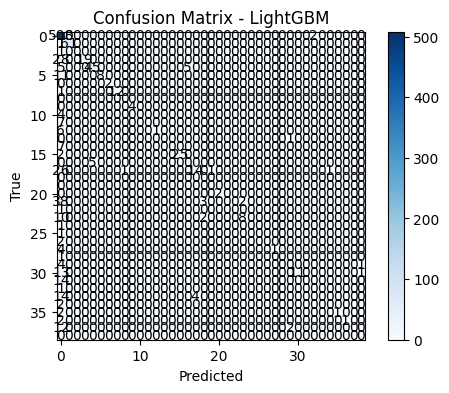

Metrics DataFrame:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters
0,LightGBM,0.7415,0.3042,0.6906,0.7415,0.6807,None,7132.7586,"{'learning_rate': 0.01, 'n_estimators': 50, 'n..."


Model Performance Metrics:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,LightGBM,0.7415,0.3042,0.6906,0.7415,0.6807,None,7132.7586,"{'learning_rate': 0.01, 'n_estimators': 50, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."


In [5]:
metrics_df_family = main(X_train_merge_rfe, X_test_merge_rfe, label_column="family_label")

The family classification shows None for ROC-AUC because the time-aware split was done by family types, not individual families. As a result, some families appear only in the training or test set, causing class mismatches. This leads to missing predicted probabilities for certain classes, making ROC-AUC computation invalid or undefined.

In [6]:
display(metrics_df_family)
metrics_df_family.to_csv('outputs/2_Impact_FS/family_rfe_results2.csv', index=False)

,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Hyperparameters,Label Mapping
0,LightGBM,0.7415,0.3042,0.6906,0.7415,0.6807,None,7132.7586,"{'learning_rate': 0.01, 'n_estimators': 50, 'n...","{0: np.int64(0), 1: np.int64(1), 2: np.int64(2..."
